In [130]:
import pickle
import numpy as np
import networkx as nx
import random
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Code for the graph : has been generating using ChatGPT
# Most of the code for Node2Vec has been written by me with the help of the paper and later I also referred to the following link for some help 
# https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py

In [131]:
with open("country_graph.pkl", "rb") as f:
    country_graph = pickle.load(f)

In [132]:
print(country_graph)

DiGraph with 197 nodes and 2088 edges


In [133]:
# function to mask our some edge before training 
def mask_edges(G, test_size):
    edges = list(G.edges())
    random.shuffle(edges)
    num_test_edges = int(len(edges) * test_size)

    test_edges = edges[:num_test_edges]
    train_edges = edges[num_test_edges:]
    
    G_train = G.copy()
    G_train.remove_edges_from(test_edges)
    return G_train, test_edges

In [134]:

class Node2VecOnGraph () : 
    def __init__ (self, G, p , q , num_walks , walk_length) : 
        '''
        G : networkx graph
        p , q are the hyperparameters for controlling the random walk   
        '''
        self.G = G
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.node2vec_walks = self.generate_walks()

    def node2vec_walk (self, node) :
        '''
        Given an input node , this function generates a 2nd order biased random walk of length l 
        '''

        length = self.walk_length
        walk = [node] # we already have one node in our collectoin 
        for i in range (0 , length - 1) : 
            cur = walk[-1] # last node in the walk
            neighbors = list(self.G.neighbors(cur))

            if not neighbors:
                if len(walk) > 1:
                    walk.append(walk[-2]) # only possible is to backtrack to the previous node
                    continue
                else:
                    break  # however this case won't happen in our case as we have outdegree of atleast 1 for each node
            

            if len(walk) == 1: # no previous node so no 1/p probability
                next_node = random.choice(neighbors) # randomly choose a neighbor as all have same probablity 

            else:
                prev = walk[-2] # previous node
                probabilities = []
                candidate_nodes = [] # list of neighbors to choose from

                for neighbor in neighbors:
                    if neighbor == prev:
                        prob = 1 / self.p  # Backtracking
                    elif self.G.has_edge(prev, neighbor):
                        prob = 1  # Directly connected to the previous node
                    else:
                        prob = 1 / self.q  # Not directly connected

                    candidate_nodes.append(neighbor)
                    probabilities.append(prob)

                # Normalize probabilities
                probabilities = np.array(probabilities, dtype=np.float64)
                probabilities /= probabilities.sum()


                next_node = random.choices(candidate_nodes, weights=probabilities)[0]
            walk.append(next_node)

        return walk
    

    def generate_walks (self) :
        '''
        Generate random walks for each node in the graph
        '''
        walks = []
        nodes = list(self.G.nodes())

        for _ in range(self.num_walks):
            for node in nodes:
                walks.append(self.node2vec_walk(node))
        return walks
    
    def train_word2vec(self, vector_size = 16 , window=5, min_count=1, sg=1):
        """
        Train a Word2Vec model on the generated walks.
        """
        model = Word2Vec(
            self.node2vec_walks,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sg = sg
        )
        return model
    
    def get_combined_features(self, model):
        """ Return concatenated feature vectors for each node. """
        feature_dict = {}

        for node in self.G.nodes():
            word2vec_embedding = model.wv[str(node)] if str(node) in model.wv else np.zeros(model.vector_size)
            first_letter = ord(str(node)[0].lower()) - ord('a')  # Convert first letter to numerical feature
            last_letter = ord(str(node)[-1].lower()) - ord('a')  # Convert last letter to numerical feature

            # scaling the features because of nomianl gain 
            first_letter *= 10
            last_letter *= 10
            combined_feature = np.concatenate([word2vec_embedding, [first_letter], [last_letter]])
            feature_dict[node] = combined_feature

        return feature_dict
    

    def extract_embeddings(self, model):
        nodes = list(model.wv.index_to_key)
        embeddings = np.array([model.wv[node] for node in nodes])
        return nodes, embeddings
    
    def reduce_dimensions(self, embeddings, n_components=16):
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(embeddings)
        return reduced_embeddings

    def visualize_embeddings(self, embeddings, nodes, n_samples=200, num_clusters=5):
        sns.set(style="whitegrid")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
        tsne_results = tsne.fit_transform(embeddings[:n_samples])
        
        # Clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings[:n_samples])
        
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='Spectral', alpha=0.7, edgecolors='k')
        plt.colorbar(scatter, label="Cluster Assignment")
        
        for i, node in enumerate(nodes[:n_samples]):
            plt.annotate(node, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=10, color='black', alpha=0.9, fontweight='bold')
        
        plt.title("t-SNE Visualization of Node Embeddings with Clustering", fontsize=14)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.show()

    # the code for 2-d visualization has been generated by ChatGPT.
    def visualize_structural_roles(self, embeddings, nodes, G, n_samples=None, num_clusters=5):
        if n_samples is None:
                n_samples = len(nodes)
        n_samples = min(n_samples, len(nodes))
    
        # Prepare structural features
        structural_features = np.zeros((n_samples, 4))
        for i, node in enumerate(nodes[:n_samples]):
            structural_features[i, 0] = nx.degree(G, node)  # Degree
            structural_features[i, 1] = nx.clustering(G, node)  # Clustering coefficient
            # Betweenness centrality (normalized)
            structural_features[i, 2] = nx.betweenness_centrality(G)[node]
            # Eigenvector centrality
            structural_features[i, 3] = nx.eigenvector_centrality(G, max_iter=1000)[node]
        
        # Scale features
        scaler = StandardScaler()
        combined_features = np.hstack([
            embeddings[:n_samples],
            scaler.fit_transform(structural_features)
        ])
        
        # Perform clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(combined_features)
        
        # Create figure with subplots
        plt.figure(figsize=(20, 15))
        
        # 1. t-SNE visualization of embeddings
        plt.subplot(2, 2, 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
        tsne_results = tsne.fit_transform(combined_features)
        
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                            c=cluster_labels, cmap='Spectral', 
                            alpha=0.7, edgecolors='k')
        plt.colorbar(scatter, label="Structural Role Cluster")
        plt.title("Node Embeddings Clustered by Structural Role", fontsize=12)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        
        # 2. Network visualization with structural roles
        plt.subplot(2, 2, 2)
        pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)
        
        # Create a color map for visualized nodes
        node_colors = ['gray'] * len(G.nodes())
        for i, node in enumerate(nodes[:n_samples]):
            node_colors[list(G.nodes()).index(node)] = plt.cm.Spectral(cluster_labels[i] / num_clusters)
        
        nx.draw(G, pos, node_color=node_colors, node_size=100,
                edge_color='gray', alpha=0.6, with_labels=True)
        plt.title("Network with Structural Role Coloring", fontsize=12)
        
        
        plt.tight_layout()
        plt.show()

    

In [135]:
G_train, test_edges = mask_edges(country_graph, 0.15)

In [136]:
print(G_train)

DiGraph with 197 nodes and 1775 edges


In [137]:
print(test_edges)

[('Benin', 'New Zealand'), ('Panama', 'Afghanistan'), ('Comoros', 'Sweden'), ('Saint Vincent and the Grenadines', 'Sierra Leone'), ('Poland', 'Democratic Republic of Congo'), ('Antigua and Barbuda', 'Albania'), ('Mozambique', 'Estonia'), ('Austria', 'Andorra'), ('Guinea', 'Armenia'), ('Tunisia', 'Andorra'), ('Nepal', 'Lithuania'), ('Maldives', 'Saint Kitts and Nevis'), ('Saint Kitts and Nevis', 'Seychelles'), ('Costa Rica', 'Albania'), ('Indonesia', 'Andorra'), ('Syria', 'Albania'), ('Slovakia', 'Angola'), ('Nauru', 'Uganda'), ('Bulgaria', 'Azerbaijan'), ('Kenya', 'Albania'), ('New Zealand', 'Denmark'), ('Romania', 'Austria'), ('Brazil', 'Liechtenstein'), ('Moldova', 'Angola'), ('Azerbaijan', 'Norway'), ('Kiribati', 'Iraq'), ('North Korea', 'Andorra'), ('Malta', 'Australia'), ('Slovenia', 'Armenia'), ('Solomon Islands', 'South Korea'), ('Netherlands', 'Singapore'), ('Bosnia and Herzegovina', 'Algeria'), ('Namibia', 'Albania'), ('Greece', 'Ethiopia'), ('Tajikistan', 'Niue'), ('Cook Isla

In [138]:
node2vec = Node2VecOnGraph(G_train, p=1 , q=0.5, num_walks=50, walk_length=20)

In [139]:
for walk in node2vec.node2vec_walks:
    print(walk)

['Afghanistan', 'North Korea', 'Afghanistan', 'Netherlands', 'South Africa', 'Argentina', 'Afghanistan', 'Nicaragua', 'Angola', 'Azerbaijan', 'Nepal', 'Luxembourg', 'Guinea-Bissau', 'United Kingdom', 'Madagascar', 'Russia', 'Argentina', 'Angola', 'Afghanistan', 'Nicaragua']
['Albania', 'Angola', 'Afghanistan', 'North Macedonia', 'Albania', 'Argentina', 'Armenia', 'Antigua and Barbuda', 'Andorra', 'Armenia', 'Argentina', 'Angola', 'Armenia', 'Angola', 'Albania', 'Angola', 'Australia', 'Angola', 'Andorra', 'Australia']
['Algeria', 'Antigua and Barbuda', 'Australia', 'Antigua and Barbuda', 'Australia', 'Azerbaijan', 'Nigeria', 'Andorra', 'Azerbaijan', 'North Macedonia', 'Antigua and Barbuda', 'Armenia', 'Antigua and Barbuda', 'Armenia', 'Andorra', 'Armenia', 'Angola', 'Algeria', 'Angola', 'Andorra']
['Andorra', 'Antigua and Barbuda', 'Algeria', 'Azerbaijan', 'Niue', 'Estonia', 'Algeria', 'Antigua and Barbuda', 'Angola', 'Albania', 'Afghanistan', 'Nauru', 'Ukraine', 'Equatorial Guinea', 'A

In [140]:
model = node2vec.train_word2vec()

In [141]:
def generate_negative_edges(G, num_samples):
    nodes = list(G.nodes())
    negative_edges = set()
    while len(negative_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negative_edges.add((u, v))
    return list(negative_edges)

In [142]:
negative_edges = generate_negative_edges(country_graph, len(test_edges))

In [143]:
print(negative_edges)

[('South Korea', 'Iran'), ('Iran', 'Saint Vincent and the Grenadines'), ('Venezuela', 'Norway'), ('Vanuatu', 'Antigua and Barbuda'), ('Central African Republic', 'Eritrea'), ('Mexico', 'Micronesia'), ('Algeria', 'Iraq'), ('Bangladesh', 'Guinea-Bissau'), ('Norway', 'Pakistan'), ('Panama', 'Romania'), ('Cambodia', 'Kiribati'), ('Uganda', 'Norway'), ('Bahrain', 'South Korea'), ('Zambia', 'Turkmenistan'), ('Kiribati', 'Canada'), ('Kazakhstan', 'Ireland'), ('Uruguay', 'Czechia'), ('Afghanistan', 'Cuba'), ('Azerbaijan', 'Malawi'), ('Yemen', 'Sudan'), ('Bulgaria', 'Lithuania'), ('Lesotho', 'Saint Lucia'), ('Burma', 'Luxembourg'), ('Burma', 'Ghana'), ('Greece', 'Finland'), ('Australia', 'Lithuania'), ('Jordan', 'Mongolia'), ('Nicaragua', 'Malawi'), ('Barbados', 'Holy See'), ('Kuwait', 'Belgium'), ('Japan', 'Paraguay'), ('Ethiopia', 'El Salvador'), ('Kenya', 'Tunisia'), ('Saint Lucia', 'Malawi'), ('Portugal', 'Sierra Leone'), ('Barbados', 'Indonesia'), ('Mali', 'Mauritania'), ('Timor-Leste', 'J

In [144]:
feature_dict = node2vec.get_combined_features(model)

In [145]:
print(feature_dict['Afghanistan'].shape)
print(feature_dict['Afghanistan'][-2]) # these two index have the information about the first and the last letter about the country name
print(feature_dict['Afghanistan'][-1])
print(feature_dict['Afghanistan'][:model.vector_size].shape)

(18,)
0.0
130.0
(16,)


In [146]:
positive_edges = [(u, v) for u, v in G_train.edges()]
negative_edges = [(u, v) for u, v in generate_negative_edges(G_train, len(positive_edges))]

# Extract node2vec embeddings for edges
X = [
    np.multiply(feature_dict[u][:model.vector_size], 
                feature_dict[v][:model.vector_size])
    for u, v in (positive_edges + negative_edges)
    if u in feature_dict and v in feature_dict
]

y = [1] * len(positive_edges) + [0] * len(negative_edges)  # Labels: 1 for existing edges, 0 for non-existing

filtered_data = list(filter(lambda pair: pair[0] is not None, zip(X, y)))
X, y = zip(*filtered_data)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [147]:
print(X_train)

[[ 1.51141627e-02  3.40846404e-02  1.23170932e-01 ... -1.04564432e-02
   5.82394764e-01  4.97299219e-01]
 [ 4.24342058e-03  1.49031266e-03  3.54897293e-02 ... -5.10280886e-02
   3.79222181e-01 -1.16238775e-02]
 [-5.34250585e-02 -9.15589233e-02  1.73897184e-02 ... -2.48286011e-02
   5.47467427e-01 -1.23017512e-01]
 ...
 [-1.66012432e-03 -6.18123428e-02 -1.47847816e-01 ... -5.37295737e-02
   5.02389241e-01 -3.99836991e-02]
 [ 7.86212861e-02 -6.33894142e-02 -5.24634468e-02 ...  7.09334206e-02
   3.05111640e-01 -7.14651456e-02]
 [ 2.63650360e-01  3.76727080e-04 -1.81290897e-03 ...  2.29682153e-02
   8.20949244e-02 -7.79121171e-03]]


In [148]:
# Train the model
clf = RandomForestClassifier(n_estimators=200, random_state=56)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Link Prediction Accuracy: {accuracy:.4f}")
print(f"Link Prediction AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")


Link Prediction Accuracy: 0.8366
Link Prediction AUC-ROC: 0.8379


In [149]:
positive_edges = [(u, v) for u, v in G_train.edges()]
negative_edges = [(u, v) for u, v in generate_negative_edges(G_train, len(positive_edges))]

X = [
    np.multiply(feature_dict[u], 
                feature_dict[v])
    for u, v in (positive_edges + negative_edges)
    if u in feature_dict and v in feature_dict
]

y = [1] * len(positive_edges) + [0] * len(negative_edges)  # Labels: 1 for existing edges, 0 for non-existing

X, y = zip(*[(x, label) for x, label in zip(X, y) if x is not None])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [150]:
# Train the model
clf = RandomForestClassifier(n_estimators=200, random_state=56)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Link Prediction Accuracy: {accuracy:.4f}")
print(f"Link Prediction AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")

Link Prediction Accuracy: 0.8718
Link Prediction AUC-ROC: 0.8730


In [151]:
# Given two nodes , predict if there is an edge between them or not and return the probability of the edge
def predict_edge (node1 , node2 , model , feature_dict , clf) :
    if node1 not in feature_dict or node2 not in feature_dict : 
        return 0
    else : 
        feature = np.multiply(feature_dict[node1] , feature_dict[node2])
        return clf.predict_proba([feature])[0][1]

In [152]:
predict_edge('Norway' , 'Yemen' ,  model , feature_dict, clf)

0.82

In [153]:
predict_edge('India' , 'Norway' ,  model , feature_dict, clf)

0.26916666666666667

In [154]:
predict_edge('Pakistan', 'Finland',  model , feature_dict, clf)

0.18833333333333335

In [155]:
predict_edge('United Kingdom', 'Montenegro' ,  model , feature_dict, clf)


0.5294166666666666

In [156]:
predict_edge('Argentina', 'Germany' ,  model , feature_dict, clf)

0.16333333333333336

In [157]:
predict_edge('Italy', 'France' ,  model , feature_dict, clf)

0.2

In [ ]:
# on the test data set print the node names and the probability of the edge between them
for edge in test_edges:
    print(edge, predict_edge(edge[0], edge[1], model, feature_dict, clf))

In [ ]:
for edge in negative_edges:
    print(edge, predict_edge(edge[0], edge[1], model, feature_dict, clf))

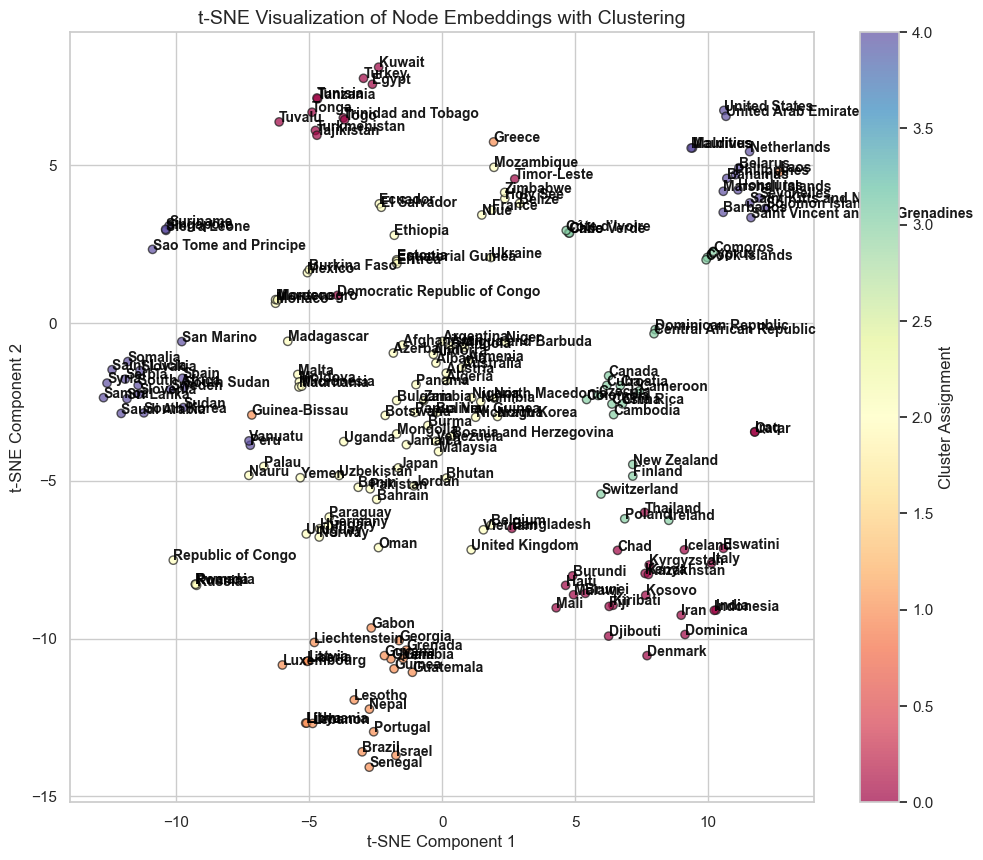

In [160]:
nodes, embeddings = node2vec.extract_embeddings(model)
reduced_embeddings = node2vec.reduce_dimensions(embeddings)
node2vec.visualize_embeddings(reduced_embeddings, nodes, num_clusters=5)


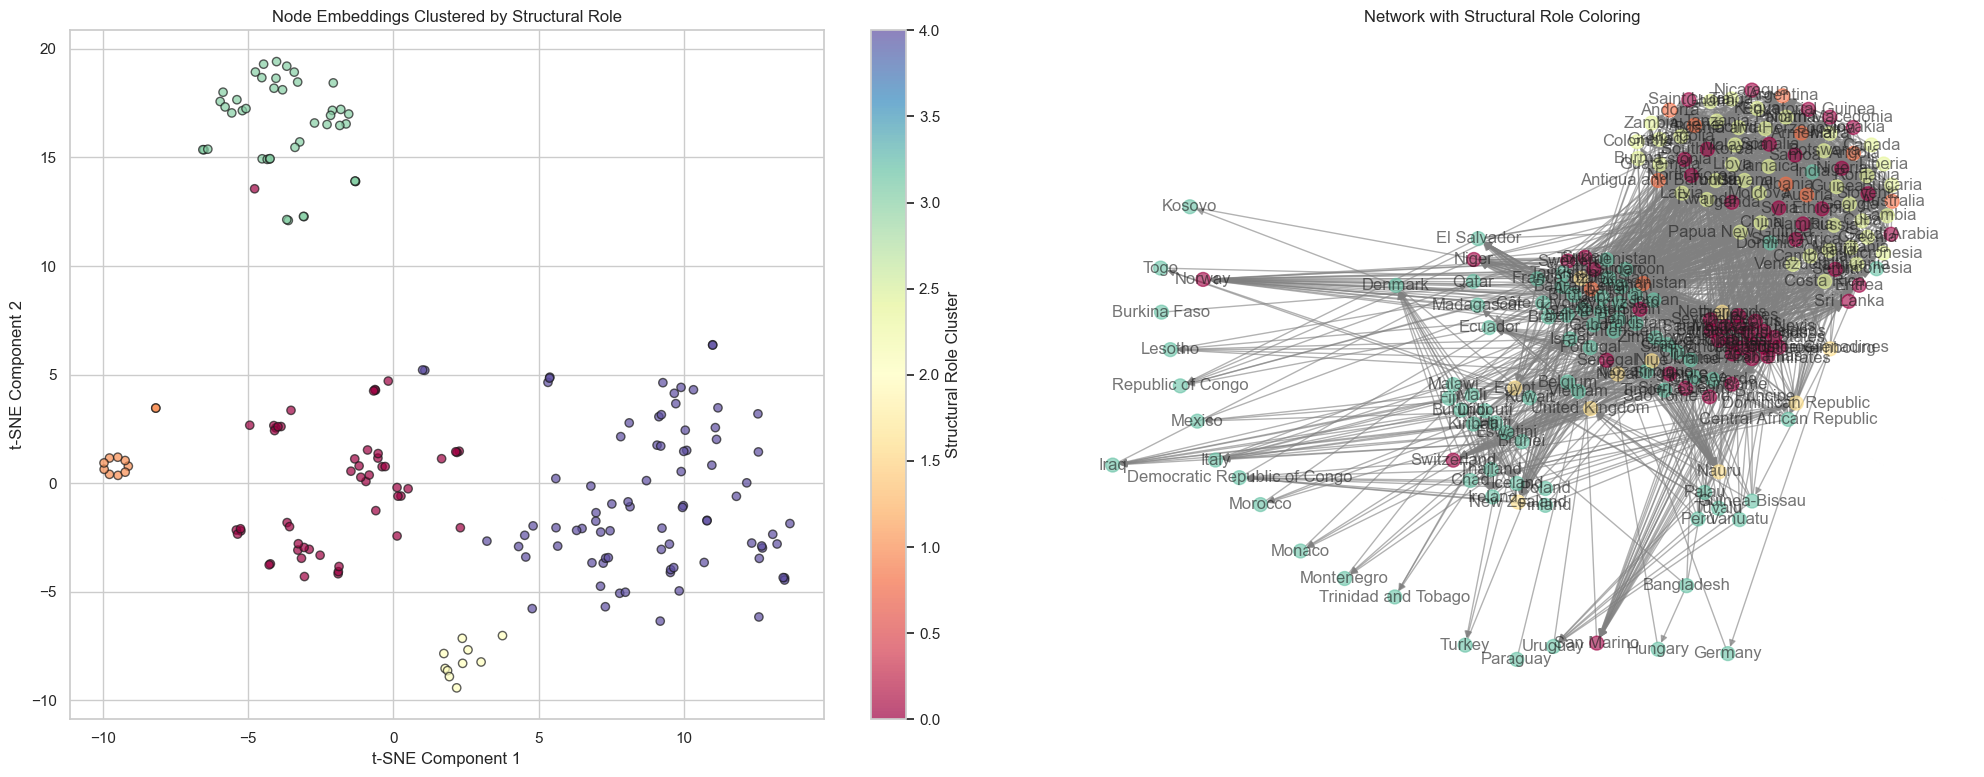

In [161]:
nodes, embeddings = node2vec.extract_embeddings(model)
reduced_embeddings = node2vec.reduce_dimensions(embeddings)
node2vec.visualize_structural_roles(
    embeddings=embeddings,
    nodes=nodes,
    G=country_graph,
    n_samples=None,  # Use all nodes
    num_clusters=5   # Number of structural role clusters to identify
)